In [611]:
from pathlib import Path
import h5py
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
import subprocess
import pybedtools
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict

In [612]:
ANNO = Path("/export/home/public/agletdinov_shared/annotations")

In [613]:
import gzip
import pandas as pd

# Функция для чтения GTF-файла и подсчета уникальных генов
def count_genes_in_gtf(gtf_file):
    # Открываем файл
    with gzip.open(gtf_file, 'rt') as f:
        # Считываем строки, относящиеся к генам
        gene_lines = [line for line in f if 'gene' in line and line.split('\t')[2] == 'gene']
        
    # Выделяем ID генов из строк
    gene_ids = set()
    for line in gene_lines:
        # Разбиваем строку на колонки
        columns = line.split('\t')
        # Последняя колонка содержит атрибуты, ищем gene_id
        attributes = columns[8]
        for attribute in attributes.split(';'):
            if 'gene_id' in attribute:
                gene_id = attribute.split('"')[1]
                gene_ids.add(gene_id)
                break
    
    return len(gene_ids)

In [614]:
# Указываем путь к файлу
gtf_file_g31 = ANNO / "gencode.v31.annotation.gtf.gz"
gene_count_g31 = count_genes_in_gtf(gtf_file_g31)
print(f'Number of unique genes: {gene_count_g31}')

Number of unique genes: 60603


In [615]:
! zless {gtf_file_g31} | head

##description: evidence-based annotation of the human genome (GRCh38), version 31 (Ensembl 97)
##provider: GENCODE
##contact: gencode-help@ebi.ac.uk
##format: gtf
##date: 2019-06-27
chr1	HAVANA	gene	11869	14409	.	+	.	gene_id "ENSG00000223972.5"; gene_type "transcribed_unprocessed_pseudogene"; gene_name "DDX11L1"; level 2; hgnc_id "HGNC:37102"; havana_gene "OTTHUMG00000000961.2";
chr1	HAVANA	transcript	11869	14409	.	+	.	gene_id "ENSG00000223972.5"; transcript_id "ENST00000456328.2"; gene_type "transcribed_unprocessed_pseudogene"; gene_name "DDX11L1"; transcript_type "lncRNA"; transcript_name "DDX11L1-202"; level 2; transcript_support_level "1"; hgnc_id "HGNC:37102"; tag "basic"; havana_gene "OTTHUMG00000000961.2"; havana_transcript "OTTHUMT00000362751.1";
chr1	HAVANA	exon	11869	12227	.	+	.	gene_id "ENSG00000223972.5"; transcript_id "ENST00000456328.2"; gene_type "transcribed_unprocessed_pseudogene"; gene_name "DDX11L1"; transcript_type "lncRNA"; transcript_name "DDX11L1-202"; exon_numbe

In [616]:
# Указываем путь к файлу
gtf_file_g31_chr = ANNO / "gencode.v31.chr_patch_hapl_scaff.annotation.gtf.gz"
gene_count_g31_chr = count_genes_in_gtf(gtf_file_g31_chr)
print(f'Number of unique genes: {gene_count_g31_chr}')

Number of unique genes: 66738


In [617]:
! zless {gtf_file_g31_chr} | head

##description: evidence-based annotation of the human genome (GRCh38), version 31 (Ensembl 97)
##provider: GENCODE
##contact: gencode-help@ebi.ac.uk
##format: gtf
##date: 2019-06-27
chr1	HAVANA	gene	11869	14409	.	+	.	gene_id "ENSG00000223972.5"; gene_type "transcribed_unprocessed_pseudogene"; gene_name "DDX11L1"; level 2; hgnc_id "HGNC:37102"; havana_gene "OTTHUMG00000000961.2";
chr1	HAVANA	transcript	11869	14409	.	+	.	gene_id "ENSG00000223972.5"; transcript_id "ENST00000456328.2"; gene_type "transcribed_unprocessed_pseudogene"; gene_name "DDX11L1"; transcript_type "lncRNA"; transcript_name "DDX11L1-202"; level 2; transcript_support_level "1"; hgnc_id "HGNC:37102"; tag "basic"; havana_gene "OTTHUMG00000000961.2"; havana_transcript "OTTHUMT00000362751.1";
chr1	HAVANA	exon	11869	12227	.	+	.	gene_id "ENSG00000223972.5"; transcript_id "ENST00000456328.2"; gene_type "transcribed_unprocessed_pseudogene"; gene_name "DDX11L1"; transcript_type "lncRNA"; transcript_name "DDX11L1-202"; exon_numbe

In [618]:
# Указываем путь к файлу
gtf_file_FANTOM_l2 = ANNO / "FANTOM_CAT.lv2_permissive.gtf.gz"
gene_count_FANTOM_l2 = count_genes_in_gtf(gtf_file_FANTOM_l2)
print(f'Number of unique genes: {gene_count_FANTOM_l2}')

Number of unique genes: 124245


In [619]:
! zless {gtf_file_FANTOM_l2} | head

chr1	FANTOM	gene	953490	954359	.	+	.	gene_id "CATG00000000002.1"; geneSuperClass "all_mRNA";  geneClass "coding_mRNA";  geneSubClass "unannotated_CPAT_coding"; gene_type "__na"; gene_name "CATG00000000002.1"; coding_status "coding"; cumulative_support "ENCODE:HUBDMAP"; geneCategory "__na"; DHS_type "not_DHS";
chr1	FANTOM	transcript	953490	954359	.	+	.	gene_id "CATG00000000002.1"; transcript_id "ENCT00000000144.1"; transcript_type "__na"; transcript_name "__na"; coding_status "coding"; cumulative_support "ENCODE:HUBDMAP"; TIEScore "50.17073";
chr1	FANTOM	exon	953490	954359	.	+	.	gene_id "CATG00000000002.1"; transcript_id "ENCT00000000144.1"; exon_number 1;
chr1	FANTOM	gene	4721910	4724467	.	+	.	gene_id "CATG00000000003.1"; geneSuperClass "other_RNA";  geneClass "sense_overlap_RNA";  geneSubClass "__na"; gene_type "__na"; gene_name "CATG00000000003.1"; coding_status "nonCoding"; cumulative_support "ENCODE"; geneCategory "__na"; DHS_type "not_DHS";
chr1	FANTOM	transcript	4721910	4724467	.

In [620]:
# Указываем путь к файлу
gtf_file_g19 = ANNO / "gencode.v19.annotation.gtf.gz"
gene_count_g19 = count_genes_in_gtf(gtf_file_g19)
print(f'Number of unique genes: {gene_count_g19}')

Number of unique genes: 57820


In [637]:
! zless {gtf_file_g19} | head

##description: evidence-based annotation of the human genome (GRCh37), version 19 (Ensembl 74)
##provider: GENCODE
##contact: gencode@sanger.ac.uk
##format: gtf
##date: 2013-12-05
chr1	HAVANA	gene	11869	14412	.	+	.	gene_id "ENSG00000223972.4"; transcript_id "ENSG00000223972.4"; gene_type "pseudogene"; gene_status "KNOWN"; gene_name "DDX11L1"; transcript_type "pseudogene"; transcript_status "KNOWN"; transcript_name "DDX11L1"; level 2; havana_gene "OTTHUMG00000000961.2";
chr1	HAVANA	transcript	11869	14409	.	+	.	gene_id "ENSG00000223972.4"; transcript_id "ENST00000456328.2"; gene_type "pseudogene"; gene_status "KNOWN"; gene_name "DDX11L1"; transcript_type "processed_transcript"; transcript_status "KNOWN"; transcript_name "DDX11L1-002"; level 2; tag "basic"; havana_gene "OTTHUMG00000000961.2"; havana_transcript "OTTHUMT00000362751.1";
chr1	HAVANA	exon	11869	12227	.	+	.	gene_id "ENSG00000223972.4"; transcript_id "ENST00000456328.2"; gene_type "pseudogene"; gene_status "KNOWN"; gene_name "DD

In [638]:
# Указываем путь к файлу
gtf_file_g25 = ANNO / "gencode.v25.annotation.gtf.gz"
gene_count_g25 = count_genes_in_gtf(gtf_file_g25)
print(f'Number of unique genes: {gene_count_g25}')

Number of unique genes: 58037


In [639]:
! zless {gtf_file_g25} | head

##description: evidence-based annotation of the human genome (GRCh38), version 25 (Ensembl 85)
##provider: GENCODE
##contact: gencode-help@sanger.ac.uk
##format: gtf
##date: 2016-07-15
chr1	HAVANA	gene	11869	14409	.	+	.	gene_id "ENSG00000223972.5"; gene_type "transcribed_unprocessed_pseudogene"; gene_status "KNOWN"; gene_name "DDX11L1"; level 2; havana_gene "OTTHUMG00000000961.2";
chr1	HAVANA	transcript	11869	14409	.	+	.	gene_id "ENSG00000223972.5"; transcript_id "ENST00000456328.2"; gene_type "transcribed_unprocessed_pseudogene"; gene_status "KNOWN"; gene_name "DDX11L1"; transcript_type "processed_transcript"; transcript_status "KNOWN"; transcript_name "DDX11L1-002"; level 2; transcript_support_level "1"; tag "basic"; havana_gene "OTTHUMG00000000961.2"; havana_transcript "OTTHUMT00000362751.1";
chr1	HAVANA	exon	11869	12227	.	+	.	gene_id "ENSG00000223972.5"; transcript_id "ENST00000456328.2"; gene_type "transcribed_unprocessed_pseudogene"; gene_status "KNOWN"; gene_name "DDX11L1"; tran

In [621]:
anno_g31 = pd.read_csv(gtf_file_g31, skiprows=[0,1,2,3,4], sep="\t", header=None)
anno_g31.shape

(2881886, 9)

In [622]:
anno_g31.head()

,0,1,2,3,4,5,6,7,8
0,chr1,HAVANA,gene,11869,14409,.,+,.,"gene_id ""ENSG00000223972.5""; gene_type ""transc..."
1,chr1,HAVANA,transcript,11869,14409,.,+,.,"gene_id ""ENSG00000223972.5""; transcript_id ""EN..."
2,chr1,HAVANA,exon,11869,12227,.,+,.,"gene_id ""ENSG00000223972.5""; transcript_id ""EN..."
3,chr1,HAVANA,exon,12613,12721,.,+,.,"gene_id ""ENSG00000223972.5""; transcript_id ""EN..."
4,chr1,HAVANA,exon,13221,14409,.,+,.,"gene_id ""ENSG00000223972.5""; transcript_id ""EN..."


In [623]:
anno_g31_chr = pd.read_csv(gtf_file_g31_chr, skiprows=[0,1,2,3,4], sep="\t", header=None)
anno_g31_chr.shape

(3129291, 9)

In [624]:
anno_g31_chr.head()

,0,1,2,3,4,5,6,7,8
0,chr1,HAVANA,gene,11869,14409,.,+,.,"gene_id ""ENSG00000223972.5""; gene_type ""transc..."
1,chr1,HAVANA,transcript,11869,14409,.,+,.,"gene_id ""ENSG00000223972.5""; transcript_id ""EN..."
2,chr1,HAVANA,exon,11869,12227,.,+,.,"gene_id ""ENSG00000223972.5""; transcript_id ""EN..."
3,chr1,HAVANA,exon,12613,12721,.,+,.,"gene_id ""ENSG00000223972.5""; transcript_id ""EN..."
4,chr1,HAVANA,exon,13221,14409,.,+,.,"gene_id ""ENSG00000223972.5""; transcript_id ""EN..."


In [625]:
# Указываем путь к файлу
gtf_file_GRCh37 = ANNO / "Homo_sapiens.GRCh37.87.chr_patch_hapl_scaff.gtf.gz"
anno_GRCh37 = pd.read_csv(gtf_file_GRCh37, skiprows=[0,1,2,3,4], sep="\t", header=None)
anno_GRCh37.shape

/tmp/ipykernel_80267/437807529.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  anno_GRCh37 = pd.read_csv(gtf_file_GRCh37, skiprows=[0,1,2,3,4], sep="\t", header=None)


(2856446, 9)

In [626]:
anno_GRCh37.head()

,0,1,2,3,4,5,6,7,8
0,1,ensembl_havana,gene,11869,14412,.,+,.,"gene_id ""ENSG00000223972""; gene_version ""4""; g..."
1,1,havana,transcript,11869,14409,.,+,.,"gene_id ""ENSG00000223972""; gene_version ""4""; t..."
2,1,havana,exon,11869,12227,.,+,.,"gene_id ""ENSG00000223972""; gene_version ""4""; t..."
3,1,havana,exon,12613,12721,.,+,.,"gene_id ""ENSG00000223972""; gene_version ""4""; t..."
4,1,havana,exon,13221,14409,.,+,.,"gene_id ""ENSG00000223972""; gene_version ""4""; t..."


In [627]:
anno_FANTOM_l2 = pd.read_csv(gtf_file_FANTOM_l2, sep="\t", header=None)
anno_FANTOM_l2.shape

(5181581, 9)

In [628]:
anno_FANTOM_l2.head()

,0,1,2,3,4,5,6,7,8
0,chr1,FANTOM,gene,953490,954359,.,+,.,"gene_id ""CATG00000000002.1""; geneSuperClass ""a..."
1,chr1,FANTOM,transcript,953490,954359,.,+,.,"gene_id ""CATG00000000002.1""; transcript_id ""EN..."
2,chr1,FANTOM,exon,953490,954359,.,+,.,"gene_id ""CATG00000000002.1""; transcript_id ""EN..."
3,chr1,FANTOM,gene,4721910,4724467,.,+,.,"gene_id ""CATG00000000003.1""; geneSuperClass ""o..."
4,chr1,FANTOM,transcript,4721910,4724467,.,+,.,"gene_id ""CATG00000000003.1""; transcript_id ""EN..."


In [631]:
anno_g19 = pd.read_csv(gtf_file_g19, sep="\t", skiprows=[0,1,2,3,4], header=None)
anno_g19.shape

(2619444, 9)

In [632]:
anno_g19.head()

,0,1,2,3,4,5,6,7,8
0,chr1,HAVANA,gene,11869,14412,.,+,.,"gene_id ""ENSG00000223972.4""; transcript_id ""EN..."
1,chr1,HAVANA,transcript,11869,14409,.,+,.,"gene_id ""ENSG00000223972.4""; transcript_id ""EN..."
2,chr1,HAVANA,exon,11869,12227,.,+,.,"gene_id ""ENSG00000223972.4""; transcript_id ""EN..."
3,chr1,HAVANA,exon,12613,12721,.,+,.,"gene_id ""ENSG00000223972.4""; transcript_id ""EN..."
4,chr1,HAVANA,exon,13221,14409,.,+,.,"gene_id ""ENSG00000223972.4""; transcript_id ""EN..."


In [640]:
anno_g25 = pd.read_csv(gtf_file_g25, sep="\t", skiprows=[0,1,2,3,4], header=None)
anno_g25.shape

(2579817, 9)

In [641]:
anno_g25.head()

,0,1,2,3,4,5,6,7,8
0,chr1,HAVANA,gene,11869,14409,.,+,.,"gene_id ""ENSG00000223972.5""; gene_type ""transc..."
1,chr1,HAVANA,transcript,11869,14409,.,+,.,"gene_id ""ENSG00000223972.5""; transcript_id ""EN..."
2,chr1,HAVANA,exon,11869,12227,.,+,.,"gene_id ""ENSG00000223972.5""; transcript_id ""EN..."
3,chr1,HAVANA,exon,12613,12721,.,+,.,"gene_id ""ENSG00000223972.5""; transcript_id ""EN..."
4,chr1,HAVANA,exon,13221,14409,.,+,.,"gene_id ""ENSG00000223972.5""; transcript_id ""EN..."


In [642]:
df_genes_dict = {}
for (i, df) in ("g31", anno_g31), ("g31_chr", anno_g31_chr), ("GRCh37", anno_GRCh37), ("FANTOM_l2", anno_FANTOM_l2), ("g19", anno_g19), ("g25", anno_g25):
    df_genes = df[df[2] == "gene"]
    df_genes["ens_gene"] = df_genes[8].apply(lambda x: x.split(" ")[1].replace('"', '').replace(';', '').split(".")[0])
    df_genes[f"genes_lenght_{i}"] = df_genes[4] - df_genes[3]
    df_genes = df_genes.rename(columns={3:f"start_{i}", 4:f"end_{i}"})
    df_genes_dict[i] = df_genes

/tmp/ipykernel_80267/3375537094.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_genes["ens_gene"] = df_genes[8].apply(lambda x: x.split(" ")[1].replace('"', '').replace(';', '').split(".")[0])
/tmp/ipykernel_80267/3375537094.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_genes[f"genes_lenght_{i}"] = df_genes[4] - df_genes[3]
/tmp/ipykernel_80267/3375537094.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [644]:
#Сравним координаты ADAR во всех аннотациях:
gene = "ENSG00000160710"

In [653]:
for i in df_genes_dict:
    subdf = df_genes_dict[i]
    print(i, subdf[subdf["ens_gene"] == gene][[f"genes_lenght_{i}"]])
    print("\n")

g31         genes_lenght_g31
168144             45956


g31_chr         genes_lenght_g31_chr
168144                 45956


GRCh37         genes_lenght_GRCh37
153225                45937


FANTOM_l2          genes_lenght_FANTOM_l2
3399181                   53492


g19         genes_lenght_g19
153472             45937


g25         genes_lenght_g25
149476             45937




In [654]:
df_genes_dict["FANTOM_l2"]

,0,1,2,start_FANTOM_l2,end_FANTOM_l2,5,6,7,8,ens_gene,genes_lenght_FANTOM_l2
0,chr1,FANTOM,gene,953490,954359,.,+,.,"gene_id ""CATG00000000002.1""; geneSuperClass ""a...",CATG00000000002,869
3,chr1,FANTOM,gene,4721910,4724467,.,+,.,"gene_id ""CATG00000000003.1""; geneSuperClass ""o...",CATG00000000003,2557
7,chr1,FANTOM,gene,47082703,47085276,.,+,.,"gene_id ""CATG00000000004.1""; geneSuperClass ""a...",CATG00000000004,2573
12,chr10,FANTOM,gene,70827747,70828440,.,-,.,"gene_id ""CATG00000000005.1""; geneSuperClass ""a...",CATG00000000005,693
15,chr10,FANTOM,gene,70829530,70830598,.,-,.,"gene_id ""CATG00000000006.1""; geneSuperClass ""a...",CATG00000000006,1068
...,...,...,...,...,...,...,...,...,...,...,...
5181501,chrY,FANTOM,gene,1446935,1461006,.,-,.,"gene_id ""ENSGR0000169100.8""; geneSuperClass ""a...",ENSGR0000169100,14071
5181525,chrY,FANTOM,gene,1531465,1606078,.,-,.,"gene_id ""ENSGR0000182162.5""; geneSuperClass ""a...",ENSGR0000182162,74613
5181532,chrY,FANTOM,gene,1264890,1281586,.,-,.,"gene_id ""ENSGR0000205755.6""; geneSuperClass ""a...",ENSGR0000205755,16696
5181560,chrY,FANTOM,gene,2354455,2370858,.,-,.,"gene_id ""ENSGR0000214717.5""; geneSuperClass ""a...",ENSGR0000214717,16403


In [566]:
df_genes_dict["GRCh37"][df_genes_dict["GRCh37"]["ens_gene"] == "ENSG00000251562"]

,0,1,2,start_GRCh37,end_GRCh37,5,6,7,8,ens_gene,genes_lenght_GRCh37
1493336,11,ensembl_havana,gene,65265233,65273940,.,+,.,"gene_id ""ENSG00000251562""; gene_version ""3""; g...",ENSG00000251562,8707


In [635]:
merge = pd.merge(left=df_genes_dict["g31"][["start_g31","end_g31", "ens_gene", "genes_lenght_g31"]], left_on="ens_gene",
         right=df_genes_dict["FANTOM_l2"][["start_FANTOM_l2","end_FANTOM_l2", "ens_gene", "genes_lenght_FANTOM_l2"]], right_on="ens_gene")
merge.head()

,start_g31,end_g31,ens_gene,genes_lenght_g31,start_FANTOM_l2,end_FANTOM_l2,genes_lenght_FANTOM_l2
0,629062,629433,ENSG00000225972,371,564589,567123,2534
1,629640,630683,ENSG00000225630,1043,565381,566063,682
2,631074,632616,ENSG00000237973,1542,566761,567996,1235
3,632757,633438,ENSG00000229344,681,568194,568818,624
4,633535,633741,ENSG00000240409,206,568915,569121,206


In [636]:
merge = pd.merge(left=df_genes_dict["g19"][["start_g19","end_g19", "ens_gene", "genes_lenght_g19"]], left_on="ens_gene",
         right=df_genes_dict["FANTOM_l2"][["start_FANTOM_l2","end_FANTOM_l2", "ens_gene", "genes_lenght_FANTOM_l2"]], right_on="ens_gene")
merge.head()

,start_g19,end_g19,ens_gene,genes_lenght_g19,start_FANTOM_l2,end_FANTOM_l2,genes_lenght_FANTOM_l2
0,562757,564390,ENSG00000223659,1633,562757,564475,1718
1,564442,564813,ENSG00000225972,371,564589,567123,2534
2,565020,566063,ENSG00000225630,1043,565381,566063,682
3,566454,567996,ENSG00000237973,1542,566761,567996,1235
4,568137,568818,ENSG00000229344,681,568194,568818,624


In [567]:
merge[merge["ens_gene"] == "CATG00000000002"]

,start_g31,end_g31,ens_gene,genes_lenght_g31,start_FANTOM_l2,end_FANTOM_l2,genes_lenght_FANTOM_l2,start_delta,end_delta,delta,lenght_delta


In [568]:
df_genes_dict["FANTOM_l2"][df_genes_dict["FANTOM_l2"]["ens_gene"] == "CATG00000000002"]

,0,1,2,start_FANTOM_l2,end_FANTOM_l2,5,6,7,8,ens_gene,genes_lenght_FANTOM_l2
0,chr1,FANTOM,gene,953490,954359,.,+,.,"gene_id ""CATG00000000002.1""; geneSuperClass ""a...",CATG00000000002,869


In [125]:
merge.shape

(36350, 5)

In [129]:
merge["start_delta"] = np.abs(merge["start_g31"] - merge["start_FANTOM_l2"])
merge["end_delta"] = np.abs(merge["end_g31"] - merge["end_FANTOM_l2"])
merge["delta"] = merge["start_delta"] + merge["end_delta"]

Text(0.5, 0, 'log10(delta)')

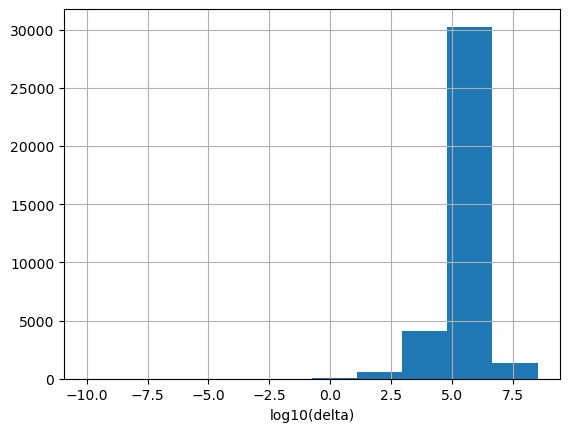

In [130]:
np.log10(merge["delta"]+1e-10).hist().set_xlabel("log10(delta)")

<Axes: >

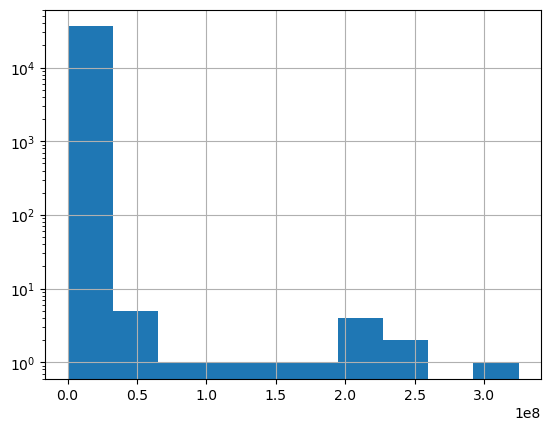

In [131]:
merge["delta"].hist(log=True, )

In [133]:
merge["lenght_delta"] = np.abs(merge["genes_lenght_g31"] - merge["genes_lenght_FANTOM_l2"])

<Axes: >

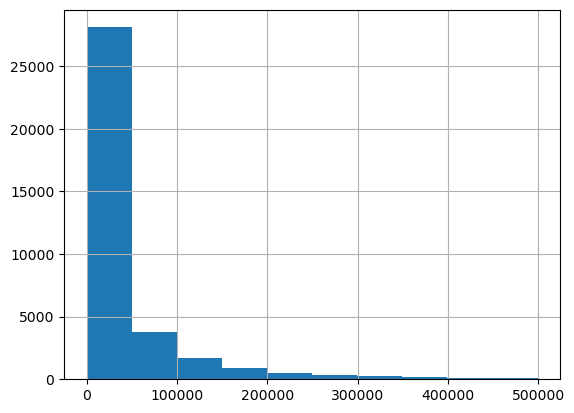

In [149]:
mask = merge["genes_lenght_g31"] < 0.5e6
merge["genes_lenght_g31"][mask].hist()

<Axes: >

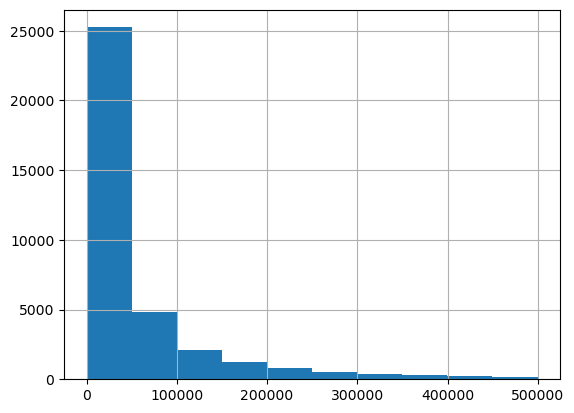

In [150]:
mask = merge["genes_lenght_FANTOM_l2"] < 0.5e6
merge["genes_lenght_FANTOM_l2"][mask].hist()

<Axes: >

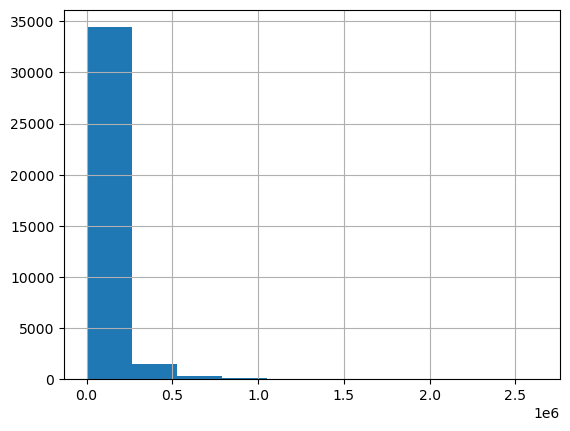

In [141]:
merge["genes_lenght_FANTOM_l2"].hist()

Text(0.5, 0, 'log10(delta)')

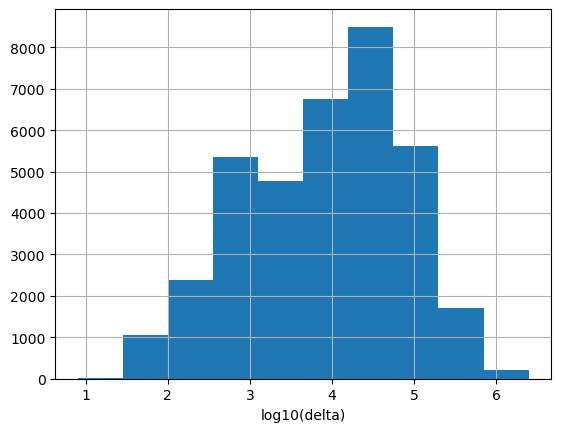

In [136]:
np.log10(merge["genes_lenght_g31"]+1e-10).hist().set_xlabel("log10(delta)")

Text(0.5, 0, 'log10(delta)')

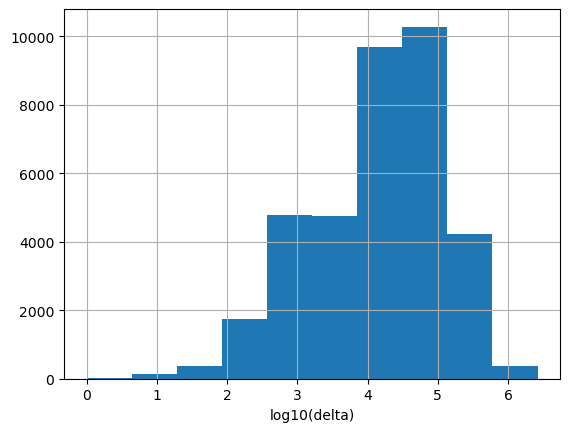

In [137]:
np.log10(merge["genes_lenght_FANTOM_l2"]+1e-10).hist().set_xlabel("log10(delta)")

Text(0.5, 0, 'log10(delta)')

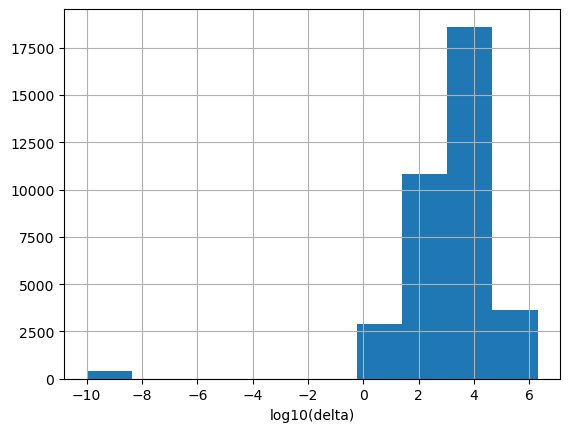

In [135]:
np.log10(merge["lenght_delta"]+1e-10).hist().set_xlabel("log10(delta)")

In [132]:
pd.set_option('display.max_rows', 100)
merge.sort_values(by="delta", ascending=False).head(100)

,start_g31,end_g31,ens_gene,genes_lenght_g31,start_FANTOM_l2,end_FANTOM_l2,genes_lenght_FANTOM_l2,start_delta,end_delta,delta
7655,163470205,163470266,ENSG00000238924,61,1088233,1088622,389,162381972,162381644,324763616
17571,128745857,128746138,ENSG00000203286,281,3452305,3478284,25979,125293552,125267854,250561406
1927,148739379,148739479,ENSG00000252515,100,25667030,25667525,495,123072349,123071954,246144303
36311,57184101,57197337,ENSG00000124334,13236,155227361,155243744,16383,98043260,98046407,196089667
36310,57067865,57130289,ENSG00000124333,62424,155111008,155174045,63037,98043143,98043756,196086899
36312,57190738,57208756,ENSG00000270726,18018,155232394,155251901,19507,98041656,98043145,196084801
36309,56954332,56968979,ENSG00000168939,14647,154842021,155016626,174605,97887689,98047647,195935336
8215,9711953,9712233,ENSG00000203436,280,95371802,95372856,1054,85659849,85660623,171320472
35898,120503037,120503096,ENSG00000251707,59,53134807,53165733,30926,67368230,67337363,134705593
31491,23827162,23828049,ENSG00000225178,887,73974309,73992659,18350,50147147,50164610,100311757


In [560]:
merge[(merge["genes_lenght_g31"] == merge["genes_lenght_FANTOM_l2"])]

,start_g31,end_g31,ens_gene,genes_lenght_g31,start_FANTOM_l2,end_FANTOM_l2,genes_lenght_FANTOM_l2,start_delta,end_delta,delta,lenght_delta
4,633535,633741,ENSG00000240409,206,568915,569121,206,64620,64620,129240,0
105,2528745,2530263,ENSG00000197921,1518,2460184,2461702,1518,68561,68561,137122,0
202,8893409,8894151,ENSG00000238249,742,8953468,8954210,742,60059,60059,120118,0
251,11029659,11030528,ENSG00000271895,869,11089716,11090585,869,60057,60057,120114,0
254,11068471,11073097,ENSG00000226849,4626,11128528,11133154,4626,60057,60057,120114,0
...,...,...,...,...,...,...,...,...,...,...,...
36127,151716035,151723194,ENSG00000147378,7159,150884507,150891666,7159,831528,831528,1663056,0
36132,152114994,152138556,ENSG00000266560,23562,151283466,151307028,23562,831528,831528,1663056,0
36270,10200155,10200306,ENSG00000251705,151,10037764,10037915,151,162391,162391,324782,0
36292,18116848,18117007,ENSG00000252166,159,20278734,20278893,159,2161886,2161886,4323772,0


In [108]:
df_genes_dict["g31"][df_genes_dict["g31"]["ens_gene"] == "ENSG00000238924"]

,0,1,2,start_g31,end_g31,5,6,7,8,ens_gene,genes_lenght
627442,chr3,ENSEMBL,gene,163470205,163470266,.,-,.,"gene_id ""ENSG00000238924.2""; gene_type ""snRNA""...",ENSG00000238924,61


In [109]:
df_genes_dict["FANTOM_l2"][df_genes_dict["FANTOM_l2"]["ens_gene"] == "ENSG00000238924"]

,0,1,2,start_FANTOM_l2,end_FANTOM_l2,5,6,7,8,ens_gene,genes_lenght
4912115,chr10,FANTOM,gene,1088233,1088622,.,-,.,"gene_id ""ENSG00000238924.1""; geneSuperClass ""s...",ENSG00000238924,389


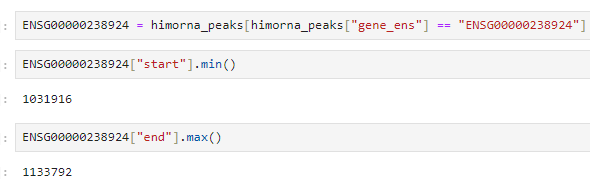

In [110]:
1133792 - 1088622

45170

In [118]:
DATA = Path("../data")
HIMORNA = DATA / "himorna_peaks"

to_peaks = HIMORNA / "Himorna_all.tsv.gz"
himorna_peaks = pd.read_csv(
        to_peaks,
        chunksize=100000000,
        sep="\t",
        usecols=["hm", "lnc", "lnc_ens", "peak", "chrom", "start", "end", "gene", "gene_ens", "corr"]
    )
himorna_peaks = pd.concat(himorna_peaks)
#to_save =  HIMORNA / "Himorna_all.tsv.gz"
#himorna_peaks_all.to_csv(to_save, sep="\t", compression="gzip", index=False)  

In [159]:
himorna_peaks.shape

(104264744, 10)

In [158]:
himorna_peaks.head()

,hm,lnc,lnc_ens,peak,chrom,start,end,gene,gene_ens,corr
0,H3K27ac,AP005060.1,ENSG00000279885,peak_389211,chr18,10441312,10441530,NaN,NaN,0.500356
1,H3K27ac,AC012409.3,ENSG00000277135,peak_389211,chr18,10441312,10441530,NaN,NaN,0.480105
2,H3K27ac,AC116651.1,ENSG00000273133,peak_389211,chr18,10441312,10441530,NaN,NaN,0.450511
3,H3K27ac,AGAP11,ENSG00000271880,peak_389211,chr18,10441312,10441530,NaN,NaN,0.491645
4,H3K27ac,AC015961.2,ENSG00000267707,peak_389211,chr18,10441312,10441530,NaN,NaN,0.473911


0         CATG00000000002
1         CATG00000000003
2         CATG00000000004
3         CATG00000000005
4         CATG00000000006
               ...       
124240    ENSGR0000169100
124241    ENSGR0000182162
124242    ENSGR0000205755
124243    ENSGR0000214717
124244    ENSGR0000225661
Name: ens_gene, Length: 124245, dtype: object

In [608]:
len(set(himorna_peaks["lnc_ens"]))

4145

In [609]:
len(set(himorna_peaks["lnc_ens"]) - set(fantom_lN['FANTOM_CAT.lv1_raw.info_table.gene.tsv']["ens_gene"]))

1232

In [610]:
set(himorna_peaks["lnc_ens"]) - set(fantom_lN['FANTOM_CAT.lv1_raw.info_table.gene.tsv']["ens_gene"])

{'ENSG00000279645',
 'ENSG00000257900',
 'ENSG00000280007',
 'ENSG00000235314',
 'ENSG00000277151',
 'ENSG00000280279',
 'ENSG00000278932',
 'ENSG00000259694',
 'ENSG00000273599',
 'ENSG00000275383',
 'ENSG00000276417',
 'ENSG00000278467',
 'ENSG00000275055',
 'ENSG00000280000',
 'ENSG00000259668',
 'ENSG00000281852',
 'ENSG00000279520',
 'ENSG00000279589',
 'ENSG00000279196',
 'ENSG00000280376',
 'ENSG00000278434',
 'ENSG00000282508',
 'ENSG00000277369',
 'ENSG00000282692',
 'ENSG00000262772',
 'ENSG00000231305',
 'ENSG00000279799',
 'ENSG00000279605',
 'ENSG00000273680',
 'ENSG00000275850',
 'ENSG00000225300',
 'ENSG00000260895',
 'ENSG00000264083',
 'ENSG00000277806',
 'ENSG00000279557',
 'ENSG00000280037',
 'ENSG00000279415',
 'ENSG00000228434',
 'ENSG00000280372',
 'ENSG00000249731',
 'ENSG00000279114',
 'ENSG00000279352',
 'ENSG00000254929',
 'ENSG00000280365',
 'ENSG00000280063',
 'ENSG00000259628',
 'ENSG00000279495',
 'ENSG00000279759',
 'ENSG00000279416',
 'ENSG00000275367',


In [606]:
himorna_peaks["lnc_ens"]

0            ENSG00000279885
1            ENSG00000277135
2            ENSG00000273133
3            ENSG00000271880
4            ENSG00000267707
                  ...       
104264739    ENSG00000259438
104264740    ENSG00000229587
104264741    ENSG00000229587
104264742    ENSG00000229587
104264743    ENSG00000229587
Name: lnc_ens, Length: 104264744, dtype: object

In [605]:
fantom_lN['FANTOM_CAT.lv2_permissive.info_table.gene.tsv']["ens_gene"]

0         CATG00000000002
1         CATG00000000003
2         CATG00000000004
3         CATG00000000005
4         CATG00000000006
               ...       
124240    ENSGR0000169100
124241    ENSGR0000182162
124242    ENSGR0000205755
124243    ENSGR0000214717
124244    ENSGR0000225661
Name: ens_gene, Length: 124245, dtype: object

In [571]:
himorna_peaks["gene_ens"].nunique()

123350

In [570]:
df_genes_dict["FANTOM_l2"]["ens_gene"].nunique()

124245

In [581]:
set(himorna_peaks["gene_ens"]) - set(df_genes_dict["FANTOM_l2"]["ens_gene"])

{'CATGC0000023317',
 'CATGE0000171943',
 'CATGR0000016925',
 'CATGR0000023020',
 'CATGR0000028081',
 'CATGR0000036577',
 'CATGR0000042263',
 'CATGR0000043351',
 nan}

In [587]:
fantom_lN = {i.stem:pd.read_csv(i, sep="\t") for i in Path("../data/fantom_cat").glob("*tsv.gz")}

In [591]:
fantom_lN["FANTOM_CAT.lv1_raw.info_table.gene.tsv"]["ens_gene"].nunique()

147173

In [588]:
himmorna_missing = {}
for i in fantom_lN:
    fantom_lN[i]["ens_gene"] = fantom_lN[i]["geneID"].apply(lambda x: x.split(".")[0])
    himmorna_missing[i] = len(set(himorna_peaks["gene_ens"].unique()) - set(fantom_lN[i]["ens_gene"].unique()))

In [589]:
himmorna_missing

{'FANTOM_CAT.lv2_permissive.info_table.gene.tsv': 9,
 'FANTOM_CAT.lv3_robust.info_table.gene.tsv': 64525,
 'FANTOM_CAT.lv4_stringent.info_table.gene.tsv': 91928,
 'FANTOM_CAT.lv1_raw.info_table.gene.tsv': 9}

In [163]:
himorna_peaks_with_genes = himorna_peaks.dropna(subset=["gene_ens"])

In [164]:
himorna_peaks_with_genes.shape

(92208462, 10)

In [165]:
himorna_peaks_with_genes["gene_ens"].nunique()

123350

In [215]:
#Долго
df_genes_dict["FANTOM_l2"][df_genes_dict["FANTOM_l2"]["ens_gene"] == "CATG00000000002"]

,0,1,2,start_FANTOM_l2,end_FANTOM_l2,5,6,7,8,ens_gene,genes_lenght_FANTOM_l2
0,chr1,FANTOM,gene,953490,954359,.,+,.,"gene_id ""CATG00000000002.1""; geneSuperClass ""a...",CATG00000000002,869


In [216]:
FANTOM_l2_gene_ens_index = df_genes_dict["FANTOM_l2"].set_index("ens_gene")

In [173]:
assert len(df_genes_dict["FANTOM_l2"]) == df_genes_dict["FANTOM_l2"]["ens_gene"].nunique()

In [253]:
%%time
#Получаем коордианты каждого гена
#Долго. Поэтому будем искать по индексу
[df_genes_dict["FANTOM_l2"][df_genes_dict["FANTOM_l2"]["ens_gene"] == "CATG00000036663"] for i in range(100)]

CPU times: user 885 ms, sys: 6.68 ms, total: 892 ms
Wall time: 888 ms


[           0       1     2  start_FANTOM_l2  end_FANTOM_l2  5  6  7  \
 153552  chr1  FANTOM  gene        223013281      223013376  .  +  .   
 
                                                         8         ens_gene  \
 153552  gene_id "CATG00000036663.1"; geneSuperClass "s...  CATG00000036663   
 
         genes_lenght_FANTOM_l2  
 153552                      95  ,
            0       1     2  start_FANTOM_l2  end_FANTOM_l2  5  6  7  \
 153552  chr1  FANTOM  gene        223013281      223013376  .  +  .   
 
                                                         8         ens_gene  \
 153552  gene_id "CATG00000036663.1"; geneSuperClass "s...  CATG00000036663   
 
         genes_lenght_FANTOM_l2  
 153552                      95  ,
            0       1     2  start_FANTOM_l2  end_FANTOM_l2  5  6  7  \
 153552  chr1  FANTOM  gene        223013281      223013376  .  +  .   
 
                                                         8         ens_gene  \
 153552  gene_id "CATG000

In [268]:
a = df_genes_dict["FANTOM_l2"].set_index("ens_gene")

In [269]:
%%time
#Гораздо быстрее
x = [a.loc["CATG00000036663"] for i in range(100)]

CPU times: user 40.8 ms, sys: 1.09 ms, total: 41.9 ms
Wall time: 40.6 ms


In [256]:
%%time
FANTOM_l2_gene_ens_index.loc["CATG00000036663"]["start_FANTOM_l2"]

CPU times: user 0 ns, sys: 416 μs, total: 416 μs
Wall time: 430 μs


223013281

In [514]:
gene_coords_FANTOM_l2 = {}
for gene_ens in tqdm(himorna_peaks_with_genes["gene_ens"].unique()):
    try:
        subdf = FANTOM_l2_gene_ens_index.loc[gene_ens]
        start, end = subdf["start_FANTOM_l2"], subdf["end_FANTOM_l2"]
    except KeyError:
        continue
    gene_coords_FANTOM_l2[gene_ens] = (start, end)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 123350/123350 [00:18<00:00, 6656.93it/s]


In [515]:
len(gene_coords_FANTOM_l2)

123342

In [516]:
missing_genes = set(himorna_peaks_with_genes["gene_ens"].unique()) - set(gene_coords_FANTOM_l2.keys())
missing_genes

{'CATGC0000023317',
 'CATGE0000171943',
 'CATGR0000016925',
 'CATGR0000023020',
 'CATGR0000028081',
 'CATGR0000036577',
 'CATGR0000042263',
 'CATGR0000043351'}

In [517]:
set(gene_coords_FANTOM_l2.keys()) - set(himorna_peaks_with_genes["gene_ens"].unique())

set()

In [518]:
%%time
#Проверим скорость сейчас
x = [gene_coords_FANTOM_l2["CATG00000036663"] for i in range(100)]

CPU times: user 0 ns, sys: 31 μs, total: 31 μs
Wall time: 35.8 μs


In [519]:
delta_dict = defaultdict(list)
for (gene_ens, subdf) in tqdm(himorna_peaks_with_genes.groupby(by="gene_ens")):
    if gene_ens in missing_genes:
        continue
    min_s, max_e = subdf["start"].min(), subdf["end"].max()
    start_fantoml2, end_fantoml2 = gene_coords_FANTOM_l2[gene_ens]
    delta_dict["ens_gene"].append(gene_ens)
    delta_dict["start"].append(start_fantoml2 - min_s)
    delta_dict["end"].append(max_e - end_fantoml2)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 123350/123350 [00:41<00:00, 2994.45it/s]


In [520]:
len(delta_dict)

3

In [521]:
delta_dict_df = pd.DataFrame(delta_dict)
delta_dict_df.set_index("ens_gene", inplace=True)
delta_dict_df.head()

,start,end
ens_gene,,
CATG00000000002,-63347,102500
CATG00000000003,88477,-20258
CATG00000000004,503958,-457586
CATG00000000005,1776713,-1757133
CATG00000000006,1778496,-1759227


In [522]:
delta_dict_df.shape

(123342, 2)

In [523]:
positive_delta_df = delta_dict_df[(delta_dict_df["start"] > 0) & (delta_dict_df["end"] > 0)]
positive_delta_df.shape

(13665, 2)

array([[<Axes: title={'center': 'start'}>,
        <Axes: title={'center': 'end'}>]], dtype=object)

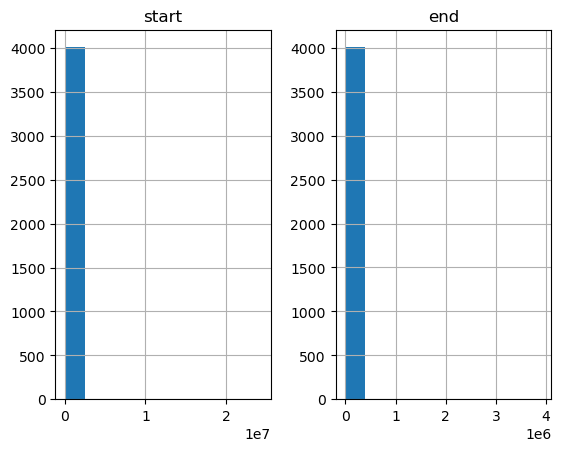

In [510]:
positive_delta_df.hist()

array([[<Axes: title={'center': 'start'}>,
        <Axes: title={'center': 'end'}>]], dtype=object)

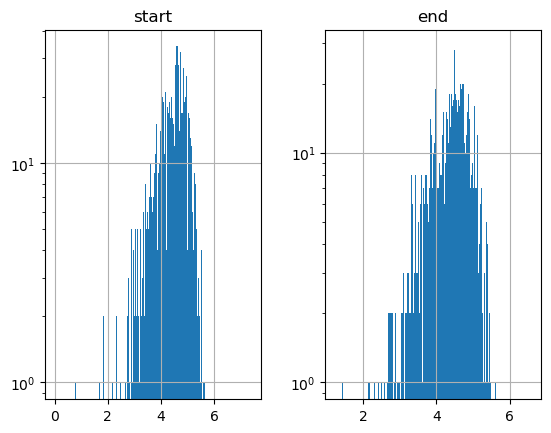

In [511]:
np.log10(positive_delta_df).hist(log=True, bins=1000)

In [512]:
np.log10(positive_delta_df)

,start,end
ens_gene,,
ENSG00000002549,3.600428,4.139533
ENSG00000002587,3.874308,3.765594
ENSG00000004468,5.059329,4.502959
ENSG00000004534,4.922689,3.612890
ENSG00000004848,4.727492,2.943989
...,...,...
ENSG00000273396,5.265374,5.004184
ENSG00000273399,3.528531,4.883718
ENSG00000273416,5.214499,2.932981


Text(0.5, 0, 'log10(delta)')

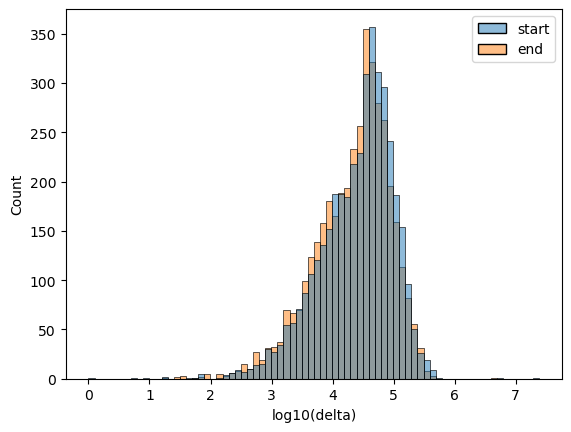

In [513]:
sns.histplot(data=np.log10(positive_delta_df), binwidth=0.1).set_xlabel("log10(delta)")

In [288]:
assert len(delta_dict_df) == len(gene_coords_FANTOM_l2)

In [289]:
delta_dict_df[delta_dict_df["start"] > 0]["start"].max()

29264700

In [290]:
delta_dict_df[delta_dict_df["end"] > 0]["end"].max()

26538136

In [351]:
g31_gene_ens_index = df_genes_dict["g31"].set_index("ens_gene")

In [352]:
len(df_genes_dict["g31"])

60603

In [353]:
df_genes_dict["g31"]["ens_gene"].nunique()

60558

In [447]:
g31_gene_ens_index = g31_gene_ens_index.drop_duplicates(subset=["start_g31", "end_g31"])
len(g31_gene_ens_index)

60547

In [448]:
assert len(df_genes_dict["g31"]) == df_genes_dict["g31"]["ens_gene"].nunique()

AssertionError: 

In [449]:
%%time
g31_gene_ens_index.loc["CATG00000036663"]

KeyError: 'CATG00000036663'

In [472]:
g31_gene_ens_index.loc["ENSG00000124333"]

,0,1,2,start_g31,end_g31,5,6,7,8,genes_lenght_g31
ens_gene,,,,,,,,,,
ENSG00000124333,chrX,HAVANA,gene,155881345,155943769,.,+,.,"gene_id ""ENSG00000124333.16""; gene_type ""prote...",62424
ENSG00000124333,chrY,HAVANA,gene,57067865,57130289,.,+,.,"gene_id ""ENSG00000124333.16_PAR_Y""; gene_type ...",62424


In [451]:
gene_coords_g31 = {}
for gene_ens in tqdm(himorna_peaks_with_genes["gene_ens"].unique()):
    try:
        subdf = g31_gene_ens_index.loc[gene_ens]
        start, end = subdf["start_g31"], subdf["end_g31"]
    except KeyError:
        continue
    gene_coords_g31[gene_ens] = (start, end)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 123350/123350 [02:29<00:00, 827.30it/s]


In [452]:
gene_coords_g31["ENSG00000002586"]

(2691187, 2741309)

In [453]:
len(gene_coords_g31)

36129

In [454]:
missing_genes = set(himorna_peaks_with_genes["gene_ens"].unique()) - set(gene_coords_g31.keys())
missing_genes

{'CATG00000005244',
 'CATG00000075947',
 'CATG00000104683',
 'CATG00000111264',
 'CATG00000039827',
 'CATG00000007128',
 'CATG00000087065',
 'CATG00000024192',
 'CATG00000054551',
 'CATG00000115536',
 'CATG00000062047',
 'CATG00000066402',
 'CATG00000045458',
 'CATG00000064066',
 'CATG00000054125',
 'CATG00000011949',
 'CATG00000051269',
 'CATG00000055727',
 'CATG00000029651',
 'CATG00000088791',
 'CATG00000035104',
 'CATG00000071121',
 'CATG00000083621',
 'CATG00000016459',
 'CATG00000077135',
 'CATG00000102031',
 'CATG00000111476',
 'CATG00000013624',
 'CATG00000004538',
 'CATG00000066700',
 'CATG00000038819',
 'CATG00000109873',
 'CATG00000080442',
 'CATG00000056756',
 'CATG00000045564',
 'CATG00000018371',
 'CATG00000060962',
 'CATG00000028174',
 'CATG00000108792',
 'CATG00000057703',
 'CATG00000002913',
 'CATG00000035812',
 'CATG00000001903',
 'CATG00000111563',
 'CATG00000028098',
 'CATG00000108092',
 'CATG00000097591',
 'CATG00000011339',
 'CATG00000047109',
 'CATG00000027955',


In [455]:
len(missing_genes)

87221

In [456]:
set(gene_coords_g31.keys()) - set(himorna_peaks_with_genes["gene_ens"].unique())

set()

In [457]:
delta_dict_g31 = defaultdict(list)
for (gene_ens, subdf) in tqdm(himorna_peaks_with_genes.groupby(by="gene_ens")):
    if gene_ens in missing_genes:
        continue
    min_s, max_e = subdf["start"].min(), subdf["end"].max()
    start_g31, end_g31 = gene_coords_g31[gene_ens]
    delta_dict_g31["ens_gene"].append(gene_ens)
    delta_dict_g31["start"].append(start_g31 - min_s)
    delta_dict_g31["end"].append(max_e - end_g31)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 123350/123350 [00:27<00:00, 4444.69it/s]


In [458]:
delta_dict_df_g31 = pd.DataFrame(delta_dict_g31)
#delta_dict_df_g31.set_index("ens_gene", inplace=True)
delta_dict_df_g31.head(26)

,ens_gene,start,end
0,ENSG00000000003,68183,71906
1,ENSG00000000005,26010,19959
2,ENSG00000000419,122540,6870
3,ENSG00000000457,61067,2126
4,ENSG00000000460,-73281,42313
5,ENSG00000000938,96983,15852
6,ENSG00000000971,2250,213585
7,ENSG00000001036,25011,75750
8,ENSG00000001084,5913,54290
9,ENSG00000001167,27762,16146


In [471]:
delta_dict_df_g31[delta_dict_df_g31["ens_gene"] == "ENSG00000124333"]

,ens_gene,start,end
5468,ENSG00000124333,ens_gene ENSG00000124333 25887 ENSG00000...,ens_gene ENSG00000124333 27287 ENSG00000...


In [459]:
delta_dict_df_g31.shape

(36129, 3)

In [460]:
delta_dict_df_g31.drop_duplicates(subset=["ens_gene"], inplace=True)

In [461]:
delta_dict_df_g31.shape

(36129, 3)

In [473]:
delta_dict_df_g31["start"]

0         68183
1         26010
2        122540
3         61067
4        -73281
          ...  
36124     27632
36125     82579
36126     17913
36127      1563
36128    246368
Name: start, Length: 36129, dtype: object

In [481]:
mask = delta_dict_df_g31["start"].apply(lambda x: True if type(x) == np.int64 else False)
delta_dict_df_g31_corrected = delta_dict_df_g31[mask]

In [482]:
for i in delta_dict_df_g31_corrected["start"]:
    if type(i) != np.int64:
        print(i)
        break

In [493]:
positive_delta_dict_df_g31 = delta_dict_df_g31_corrected[(delta_dict_df_g31_corrected["start"] > 0) & (delta_dict_df_g31_corrected["end"] > 0)]
positive_delta_dict_df_g31.shape

(34056, 3)

In [494]:
positive_delta_dict_df_g31 = positive_delta_dict_df_g31.set_index("ens_gene")
positive_delta_dict_df_g31

,start,end
ens_gene,,
ENSG00000000003,68183,71906
ENSG00000000005,26010,19959
ENSG00000000419,122540,6870
ENSG00000000457,61067,2126
ENSG00000000938,96983,15852
...,...,...
ENSG00000273481,50787,2360
ENSG00000273483,27632,122089
ENSG00000273485,82579,9012


In [498]:
positive_delta_dict_df_g31 = positive_delta_dict_df_g31.astype(int)

array([[<Axes: title={'center': 'start'}>,
        <Axes: title={'center': 'end'}>]], dtype=object)

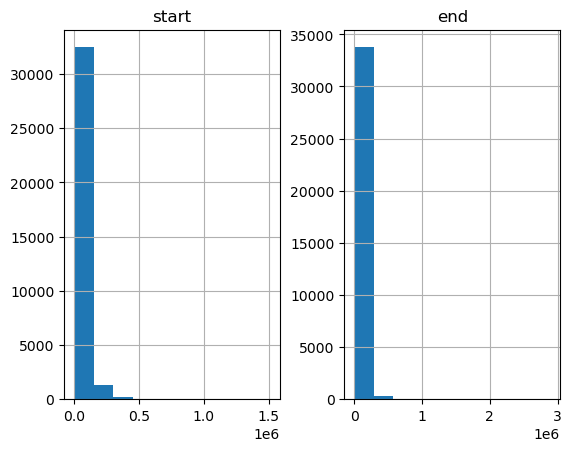

In [500]:
positive_delta_dict_df_g31.hist()

array([[<Axes: title={'center': 'start'}>,
        <Axes: title={'center': 'end'}>]], dtype=object)

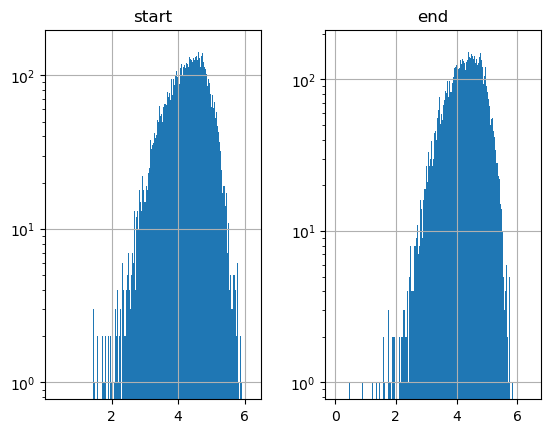

In [501]:
np.log10(positive_delta_dict_df_g31).hist(log=True, bins=1000)

In [502]:
np.log10(positive_delta_dict_df_g31)

,start,end
ens_gene,,
ENSG00000000003,4.833676,4.856765
ENSG00000000005,4.415140,4.300139
ENSG00000000419,5.088278,3.836957
ENSG00000000457,4.785807,3.327563
ENSG00000000938,4.986696,4.200084
...,...,...
ENSG00000273481,4.705753,3.372912
ENSG00000273483,4.441412,5.086677
ENSG00000273485,4.916870,3.954821


Text(0.5, 0, 'log10(delta)')

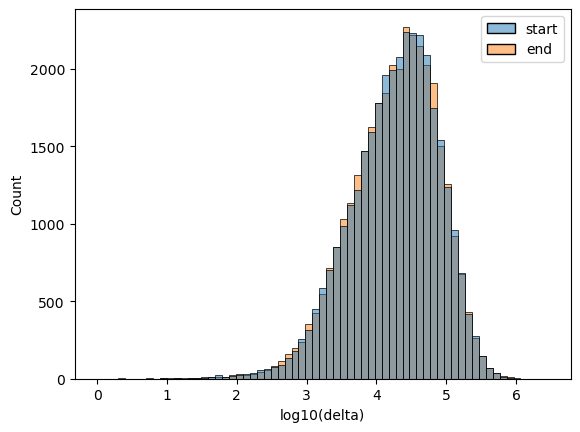

In [503]:
sns.histplot(data=np.log10(positive_delta_dict_df_g31), binwidth=0.1).set_xlabel("log10(delta)")

In [288]:
assert len(delta_dict_df) == len(gene_coords_FANTOM_l2)

In [561]:
delta_dict_df_g31_corrected[delta_dict_df_g31_corrected["start"] > 0]["start"].max()

162438289

In [562]:
delta_dict_df_g31_corrected[delta_dict_df_g31_corrected["end"] > 0]["end"].max()

84959997

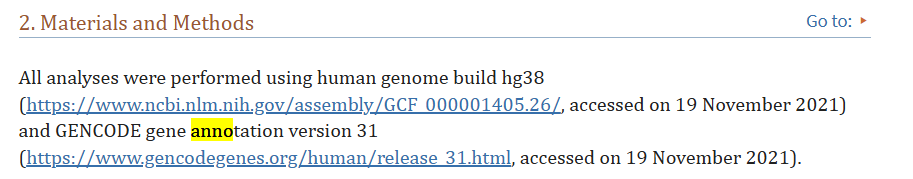

## ПРИМЕРЫ

### 1

In [526]:
a = himorna_peaks_with_genes[himorna_peaks_with_genes["gene_ens"] == "CATG00000000002"]
a

,hm,lnc,lnc_ens,peak,chrom,start,end,gene,gene_ens,corr
51832,H3K27ac,TRG-AS1,ENSG00000281103,peak_89,chr1,1018112,1018581,NaN,CATG00000000002,0.515623
51833,H3K27ac,AL355987.4,ENSG00000273066,peak_89,chr1,1018112,1018581,NaN,CATG00000000002,0.515085
51834,H3K27ac,AC079866.2,ENSG00000256571,peak_89,chr1,1018112,1018581,NaN,CATG00000000002,-0.498977
51835,H3K27ac,LINC00941,ENSG00000235884,peak_89,chr1,1018112,1018581,NaN,CATG00000000002,-0.544942
51836,H3K27ac,Z97192.3,ENSG00000235111,peak_89,chr1,1018112,1018581,NaN,CATG00000000002,0.472143
51837,H3K27ac,LINC02802,ENSG00000232527,peak_89,chr1,1018112,1018581,NaN,CATG00000000002,-0.480131
51838,H3K27ac,AC099066.2,ENSG00000227496,peak_89,chr1,1018112,1018581,NaN,CATG00000000002,-0.480946
51839,H3K27ac,CYTOR,ENSG00000222041,peak_89,chr1,1018112,1018581,NaN,CATG00000000002,-0.464773
51840,H3K27ac,C22orf34,ENSG00000188511,peak_89,chr1,1018112,1018581,NaN,CATG00000000002,0.464412
51841,H3K27ac,MIR4435-2HG,ENSG00000172965,peak_89,chr1,1018112,1018581,NaN,CATG00000000002,-0.498979


In [593]:
b = himorna_peaks_with_genes[himorna_peaks_with_genes["lnc_ens"] == "ENSG00000281103"]

In [594]:
b

,hm,lnc,lnc_ens,peak,chrom,start,end,gene,gene_ens,corr
477,H3K27ac,TRG-AS1,ENSG00000281103,peak_389237,chr18,10471682,10471849,NaN,CATG00000036919,0.510645
478,H3K27ac,TRG-AS1,ENSG00000281103,peak_389237,chr18,10471682,10471849,APCDD1,ENSG00000154856,0.510645
479,H3K27ac,TRG-AS1,ENSG00000281103,peak_389237,chr18,10471682,10471849,NaN,CATG00000036918,0.510645
672,H3K27ac,TRG-AS1,ENSG00000281103,peak_389243,chr18,10474589,10486058,APCDD1,ENSG00000154856,0.553508
673,H3K27ac,TRG-AS1,ENSG00000281103,peak_389243,chr18,10474589,10486058,NaN,CATG00000036918,0.553508
...,...,...,...,...,...,...,...,...,...,...
104245411,H4K20me1,TRG-AS1,ENSG00000281103,peak_70541,chr14,104818016,104819890,NaN,CATG00000022191,0.880426
104245412,H4K20me1,TRG-AS1,ENSG00000281103,peak_70541,chr14,104818016,104819890,ZBTB42,ENSG00000179627,0.880426
104258498,H4K20me1,TRG-AS1,ENSG00000281103,peak_73531,chr15,57619735,57619944,POLR2M,ENSG00000255529,0.862801
104258499,H4K20me1,TRG-AS1,ENSG00000281103,peak_73531,chr15,57619735,57619944,MYZAP,ENSG00000263155,0.862801


In [595]:
b["gene_ens"].nunique()

42276

In [528]:
a["start"].min(), a["end"].max()

(1016837, 1056859)

In [531]:
gene_coords_FANTOM_l2["CATG00000000002"]

(953490, 954359)

In [532]:
954359 - 953490

869

In [534]:
df_genes_dict["FANTOM_l2"][df_genes_dict["FANTOM_l2"]["ens_gene"] == "CATG00000000002"]

,0,1,2,start_FANTOM_l2,end_FANTOM_l2,5,6,7,8,ens_gene,genes_lenght_FANTOM_l2
0,chr1,FANTOM,gene,953490,954359,.,+,.,"gene_id ""CATG00000000002.1""; geneSuperClass ""a...",CATG00000000002,869


In [535]:
1056859 - 954359

102500

### 2

In [536]:
a = himorna_peaks_with_genes[himorna_peaks_with_genes["gene_ens"] == "ENSG00000160710"]
a

,hm,lnc,lnc_ens,peak,chrom,start,end,gene,gene_ens,corr
14613085,H3K27ac,LINC00528,ENSG00000269220,peak_48665,chr1,154572729,154580586,ADAR,ENSG00000160710,0.473014
14613087,H3K27ac,AC084757.3,ENSG00000259705,peak_48665,chr1,154572729,154580586,ADAR,ENSG00000160710,-0.528211
14613089,H3K27ac,PDE6B-AS1,ENSG00000242686,peak_48665,chr1,154572729,154580586,ADAR,ENSG00000160710,0.469594
14613091,H3K27ac,AC016831.1,ENSG00000226380,peak_48665,chr1,154572729,154580586,ADAR,ENSG00000160710,-0.504898
14613093,H3K27ac,AL353759.1,ENSG00000283064,peak_48670,chr1,154582603,154585669,ADAR,ENSG00000160710,0.458229
...,...,...,...,...,...,...,...,...,...,...
101158832,H3K9ac,AC079777.1,ENSG00000280083,peak_20868,chr1,154626205,154628813,ADAR,ENSG00000160710,-0.764676
101158834,H3K9ac,AL683813.2,ENSG00000232611,peak_20868,chr1,154626205,154628813,ADAR,ENSG00000160710,-0.829825
102827081,H3K9me3,DDN-AS1,ENSG00000257913,peak_14071,chr1,154628339,154631573,ADAR,ENSG00000160710,0.506191
102827083,H3K9me3,CARMN,ENSG00000249669,peak_14071,chr1,154628339,154631573,ADAR,ENSG00000160710,-0.494019


### 3

In [549]:
himorna_peaks_with_genes.groupby(by="gene_ens").agg({"peak":"nunique"}).sort_values(by="peak", ascending=False)

,peak
gene_ens,
ENSG00000185565,4050
ENSG00000269501,3923
CATG00000016100,3855
ENSG00000153707,3844
ENSG00000215861,3837
...,...
CATG00000113322,1
CATG00000113312,1
CATG00000030800,1


In [550]:
a = himorna_peaks_with_genes[himorna_peaks_with_genes["gene_ens"] == "ENSG00000185565"]
a

,hm,lnc,lnc_ens,peak,chrom,start,end,gene,gene_ens,corr
213112,H3K27ac,AC006064.5,ENSG00000276232,peak_610445,chr3,117194140,117194385,LSAMP,ENSG00000185565,-0.495706
213116,H3K27ac,AC048382.5,ENSG00000275120,peak_610445,chr3,117194140,117194385,LSAMP,ENSG00000185565,-0.432609
213120,H3K27ac,LINC01109,ENSG00000271167,peak_610445,chr3,117194140,117194385,LSAMP,ENSG00000185565,-0.469525
213124,H3K27ac,RMRP,ENSG00000269900,peak_610445,chr3,117194140,117194385,LSAMP,ENSG00000185565,-0.464021
213128,H3K27ac,LINC00211,ENSG00000237803,peak_610445,chr3,117194140,117194385,LSAMP,ENSG00000185565,-0.484130
...,...,...,...,...,...,...,...,...,...,...
104044648,H4K20me1,LIX1-AS1,ENSG00000251513,peak_146792,chr3,117962751,117963029,LSAMP,ENSG00000185565,-0.687609
104044651,H4K20me1,LIX1-AS1,ENSG00000251513,peak_146797,chr3,117973998,117976677,LSAMP,ENSG00000185565,-0.632458
104044657,H4K20me1,AC004148.1,ENSG00000263272,peak_146798,chr3,117977218,117996142,LSAMP,ENSG00000185565,-0.687144
104044663,H4K20me1,LIX1-AS1,ENSG00000251513,peak_146798,chr3,117977218,117996142,LSAMP,ENSG00000185565,-0.747451


In [551]:
a["peak"].nunique()

4050

In [552]:
#координаты самого левого и самого правого пиков
a["start"].min(), a["end"].max()

(115799038, 118001710)

In [553]:
#коорщдинаты гена в FANTOM_l2
gene_coords_FANTOM_l2["ENSG00000185565"]

(115512664, 117716426)

In [554]:
115512664 - 115799038

-286374

In [555]:
118001710 - 117716426

285284

In [556]:
#коорщдинаты гена в g31
gene_coords_g31["ENSG00000185565"]

(115802363, 117139389)

In [557]:
115802363 - 115799038

3325

In [558]:
118001710 - 117139389

862321

In [ ]:
!head /home/mazurov